<h1 align="center">Apartment Resale value Prediction</h>

In [1]:
import numpy as np
import pandas as pd
import re

#Imputers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3 

# !pip install pandasql
import pandasql as ps 

from statsmodels.graphics.gofplots import ProbPlot

#### Reading the CSV file

In [2]:
train1_df = pd.read_csv('train1.csv')
train2_df = pd.read_csv('train2.csv')
train3_df = pd.read_csv('train3.csv')
train4_df = pd.read_csv('building_to_mrt_distance.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train1_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,uniqueID
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0,100000
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0,100001
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0,100002
3,2012-03,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,320000.0,100003
4,2012-03,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,321000.0,100004


In [4]:
train2_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,uniqueID
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0,152203
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0,152204
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0,152205
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0,152206
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0,152207


In [5]:
train3_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,uniqueID
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,189356
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,189357
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,189358
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,189359
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,189360


In [6]:
print("Train 1 Shape =",train1_df.shape)
print("Train 2 Shape =",train2_df.shape)
print("Train 3 Shape =",train3_df.shape)

Train 1 Shape = (52203, 11)
Train 2 Shape = (37153, 12)
Train 3 Shape = (32578, 12)


#### Calculating the remaining lease year for dataframe 3

In [7]:
def CalculateRemaingLease(date):
    splitDate = date.split(" ")
    size = len(splitDate)
    finalYear = int(splitDate[0])
    if(size>2):
        month = int(splitDate[2])
        if(month>8):
            finalYear = finalYear+1
    return finalYear

In [8]:
train3_df['remaining_lease'] = train3_df.remaining_lease.apply(CalculateRemaingLease)

In [9]:
train3_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,uniqueID
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61,232000.0,189356
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60,250000.0,189357
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,262000.0,189358
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62,265000.0,189359
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,265000.0,189360


In [10]:
train_Merge_df = pd.concat([train2_df,train3_df])

In [11]:
train_Merge_df = pd.concat([train_Merge_df,train1_df])

In [12]:
train_Merge_df.shape

(121934, 12)

In [13]:
train_Merge_df.head(10)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,uniqueID
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70.0,255000.0,152203
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65.0,275000.0,152204
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64.0,285000.0,152205
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63.0,290000.0,152206
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64.0,290000.0,152207
5,2015-01,ANG MO KIO,3 ROOM,603,ANG MO KIO AVE 5,07 TO 09,67.0,New Generation,1980,64.0,290000.0,152208
6,2015-01,ANG MO KIO,3 ROOM,709,ANG MO KIO AVE 8,01 TO 03,68.0,New Generation,1980,64.0,290000.0,152209
7,2015-01,ANG MO KIO,3 ROOM,333,ANG MO KIO AVE 1,01 TO 03,68.0,New Generation,1981,65.0,293000.0,152210
8,2015-01,ANG MO KIO,3 ROOM,109,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,62.0,300000.0,152211
9,2015-01,ANG MO KIO,3 ROOM,564,ANG MO KIO AVE 3,13 TO 15,68.0,New Generation,1985,69.0,307500.0,152212


In [14]:
def GetCurrentYear(month):
    splitmonth = month.split("-")
    size = len(splitmonth)
    finalYear = int(splitmonth[0])
    if(size>1):
        month = int(splitmonth[1])
        if(month>8):
            finalYear = finalYear+1
    return finalYear

In [15]:
train_Merge_df['month'] = train_Merge_df.month.apply(GetCurrentYear)
train_Merge_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,uniqueID
0,2015,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70.0,255000.0,152203
1,2015,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65.0,275000.0,152204
2,2015,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64.0,285000.0,152205
3,2015,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63.0,290000.0,152206
4,2015,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64.0,290000.0,152207


In [16]:
train_Merge_df.dtypes

month                    int64
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease        float64
resale_price           float64
uniqueID                 int64
dtype: object

In [17]:
train_Merge_df['remaining_lease'] = train_Merge_df['remaining_lease'].fillna(0)

In [18]:
train_Merge_df.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
uniqueID               0
dtype: int64

In [19]:
train_Merge_df['month'] = train_Merge_df['month'].astype('int64')
train_Merge_df['town'] = train_Merge_df['town'].astype('category')
train_Merge_df['flat_type'] = train_Merge_df['flat_type'].astype('category')
train_Merge_df['block'] = train_Merge_df['block'].astype('category')
train_Merge_df['street_name'] = train_Merge_df['street_name'].astype('category')
train_Merge_df['storey_range'] = train_Merge_df['storey_range'].astype('category')
train_Merge_df['flat_model'] = train_Merge_df['flat_model'].astype('category')
train_Merge_df['remaining_lease'] = train_Merge_df['remaining_lease'].astype('int64')

In [20]:
maxLeaseYear = 99
train_Merge_df['remaining_lease'] = maxLeaseYear-(train_Merge_df['month'] - train_Merge_df['lease_commence_date'])

In [21]:
train_Merge_df.isnull().dtypes

month                  bool
town                   bool
flat_type              bool
block                  bool
street_name            bool
storey_range           bool
floor_area_sqm         bool
flat_model             bool
lease_commence_date    bool
remaining_lease        bool
resale_price           bool
uniqueID               bool
dtype: object

In [22]:
train_Merge_df['month'] = train_Merge_df['month'].astype('int64')
train_Merge_df['town'] = train_Merge_df['town'].astype('category')
train_Merge_df['flat_type'] = train_Merge_df['flat_type'].astype('category')
train_Merge_df['block'] = train_Merge_df['block'].astype('category')
train_Merge_df['street_name'] = train_Merge_df['street_name'].astype('category')
train_Merge_df['storey_range'] = train_Merge_df['storey_range'].astype('category')
train_Merge_df['floor_area_sqm'] = train_Merge_df['floor_area_sqm'].astype('float64')
train_Merge_df['flat_model'] = train_Merge_df['flat_model'].astype('category')
train_Merge_df['lease_commence_date'] = train_Merge_df['lease_commence_date'].astype('int64')
train_Merge_df['remaining_lease'] = train_Merge_df['remaining_lease'].astype('int64')
train_Merge_df['resale_price'] = train_Merge_df['resale_price'].astype('float64')
train_Merge_df['uniqueID'] = train_Merge_df['uniqueID'].astype('category')

In [23]:
train4_df.head()

,Building,Jurong East MRT station,Bukit Batok MRT station,Bukit Gombak MRT station,Choa Chu Kang MRT station,Yew Tee MRT station,Kranji MRT station,Marsiling MRT station,Woodlands MRT station,Admiralty MRT station,...,Bendemeer MRT station,Geylang Bahru MRT Station,Mattar MRT station,Ubi MRT station,Kaki Bukit MRT Station,Bedok North MRT station,Bedok Reservoir MRT station,Tampines West MRT station,Tampines East MRT station,Upper Changi MRT station
0,ANCHORVALE ST BLK 331C,17818.84265,16471.03384,15856.79247,16199.22480,15808.72792,14570.109930,13485.500120,12369.979820,11061.899320,...,9584.39327,8494.000192,7640.691202,7398.618897,7079.585070,7440.940807,8107.447171,7743.354078,8438.549604,9950.182657
1,PUNGGOL WAY BLK 266B,19092.61457,17694.05674,17032.15623,17205.95322,16731.88625,15248.533120,14065.860790,12863.730930,11445.713010,...,10932.92815,9808.425468,8872.302279,8425.747280,7957.972942,8163.873942,8589.377565,8042.543847,8366.769609,9996.575353
2,YISHUN AVE 9 BLK 318A,15919.39969,14166.65357,13182.50154,12293.68148,11439.72263,9122.636441,7722.266883,6368.157244,4795.908711,...,13570.68606,12907.865810,12661.750790,13179.447730,13208.994580,13791.613210,14675.215580,14401.138090,15072.755350,16621.097390
3,YISHUN AVE 9 BLK 318B,15903.04510,14152.90288,13171.66285,12296.13129,11447.44104,9144.786709,7748.983596,6398.540744,4831.224121,...,13515.78029,12851.563270,12604.181940,13121.274190,13151.040900,13734.103470,14618.776730,14345.977870,15020.740460,16567.813760
4,YISHUN AVE 9 BLK 315A,15705.88647,13955.91314,12975.36314,12109.29884,11267.18726,8991.283610,7607.087576,6267.390055,4716.850722,...,13402.90599,12752.522990,12524.591610,13068.535130,13115.059640,13710.617970,14613.647670,14356.366340,15058.662370,16595.614410


In [24]:
q1 = """SELECT Building FROM train4_df """
print(ps.sqldf(q1, locals()))

                       Building
0        ANCHORVALE ST BLK 331C
1          PUNGGOL WAY BLK 266B
2         YISHUN AVE 9 BLK 318A
3         YISHUN AVE 9 BLK 318B
4         YISHUN AVE 9 BLK 315A
...                         ...
8806    TELOK BLANGAH DR BLK 46
8807       BT PURMEI RD BLK 101
8808    TELOK BLANGAH DR BLK 44
8809  TELOK BLANGAH RISE BLK 42
8810  TELOK BLANGAH RISE BLK 43

[8811 rows x 1 columns]


In [25]:
train4_df.Building.unique()

array(['ANCHORVALE ST BLK 331C', 'PUNGGOL WAY BLK 266B',
       'YISHUN AVE 9 BLK 318A', ..., 'TELOK BLANGAH DR BLK 44',
       'TELOK BLANGAH RISE BLK 42', 'TELOK BLANGAH RISE BLK 43'],
      dtype=object)

#### Merging the main data frame with amenities distance data frame.

In [26]:
train_Merge_df['street_name'] = train_Merge_df['street_name'].str.cat(train_Merge_df['block'], sep =" BLK ") 

In [27]:
train_Merge_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,uniqueID
0,2015,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4 BLK 174,07 TO 09,60.0,Improved,1986,70,255000.0,152203
1,2015,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10 BLK 541,01 TO 03,68.0,New Generation,1981,65,275000.0,152204
2,2015,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4 BLK 163,01 TO 03,69.0,New Generation,1980,64,285000.0,152205
3,2015,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10 BLK 446,01 TO 03,68.0,New Generation,1979,63,290000.0,152206
4,2015,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10 BLK 557,07 TO 09,68.0,New Generation,1980,64,290000.0,152207


In [28]:
train_Merge_df.rename(columns = {"street_name": "Building", "month":"Year"},inplace = True)

In [29]:
train_Merge_df.head()

,Year,town,flat_type,block,Building,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,uniqueID
0,2015,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4 BLK 174,07 TO 09,60.0,Improved,1986,70,255000.0,152203
1,2015,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10 BLK 541,01 TO 03,68.0,New Generation,1981,65,275000.0,152204
2,2015,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4 BLK 163,01 TO 03,69.0,New Generation,1980,64,285000.0,152205
3,2015,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10 BLK 446,01 TO 03,68.0,New Generation,1979,63,290000.0,152206
4,2015,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10 BLK 557,07 TO 09,68.0,New Generation,1980,64,290000.0,152207


In [30]:
 train4_df.head()

,Building,Jurong East MRT station,Bukit Batok MRT station,Bukit Gombak MRT station,Choa Chu Kang MRT station,Yew Tee MRT station,Kranji MRT station,Marsiling MRT station,Woodlands MRT station,Admiralty MRT station,...,Bendemeer MRT station,Geylang Bahru MRT Station,Mattar MRT station,Ubi MRT station,Kaki Bukit MRT Station,Bedok North MRT station,Bedok Reservoir MRT station,Tampines West MRT station,Tampines East MRT station,Upper Changi MRT station
0,ANCHORVALE ST BLK 331C,17818.84265,16471.03384,15856.79247,16199.22480,15808.72792,14570.109930,13485.500120,12369.979820,11061.899320,...,9584.39327,8494.000192,7640.691202,7398.618897,7079.585070,7440.940807,8107.447171,7743.354078,8438.549604,9950.182657
1,PUNGGOL WAY BLK 266B,19092.61457,17694.05674,17032.15623,17205.95322,16731.88625,15248.533120,14065.860790,12863.730930,11445.713010,...,10932.92815,9808.425468,8872.302279,8425.747280,7957.972942,8163.873942,8589.377565,8042.543847,8366.769609,9996.575353
2,YISHUN AVE 9 BLK 318A,15919.39969,14166.65357,13182.50154,12293.68148,11439.72263,9122.636441,7722.266883,6368.157244,4795.908711,...,13570.68606,12907.865810,12661.750790,13179.447730,13208.994580,13791.613210,14675.215580,14401.138090,15072.755350,16621.097390
3,YISHUN AVE 9 BLK 318B,15903.04510,14152.90288,13171.66285,12296.13129,11447.44104,9144.786709,7748.983596,6398.540744,4831.224121,...,13515.78029,12851.563270,12604.181940,13121.274190,13151.040900,13734.103470,14618.776730,14345.977870,15020.740460,16567.813760
4,YISHUN AVE 9 BLK 315A,15705.88647,13955.91314,12975.36314,12109.29884,11267.18726,8991.283610,7607.087576,6267.390055,4716.850722,...,13402.90599,12752.522990,12524.591610,13068.535130,13115.059640,13710.617970,14613.647670,14356.366340,15058.662370,16595.614410


In [31]:
final_df = pd.merge(train_Merge_df,train4_df,how="inner")

In [32]:
print("Train Merge shape = ",train_Merge_df.shape)
print('final df shape = ',final_df.shape)

Train Merge shape =  (121934, 12)
final df shape =  (121934, 131)


In [33]:
train4_df.shape

(8811, 120)

In [34]:
final_df.head()

,Year,town,flat_type,block,Building,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,Bendemeer MRT station,Geylang Bahru MRT Station,Mattar MRT station,Ubi MRT station,Kaki Bukit MRT Station,Bedok North MRT station,Bedok Reservoir MRT station,Tampines West MRT station,Tampines East MRT station,Upper Changi MRT station
0,2015,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4 BLK 174,07 TO 09,60.0,Improved,1986,70,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
1,2016,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4 BLK 174,10 TO 12,60.0,Improved,1986,69,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
2,2016,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4 BLK 174,04 TO 06,69.0,Improved,1986,69,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
3,2016,ANG MO KIO,2 ROOM,174,ANG MO KIO AVE 4 BLK 174,07 TO 09,45.0,Improved,1986,69,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
4,2017,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4 BLK 174,04 TO 06,61.0,Improved,1986,68,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606


In [35]:
final_df['Building'] = final_df['Building'].astype('category')

In [36]:
final_df.dtypes

Year                              int64
town                           category
flat_type                      category
block                          category
Building                       category
                                 ...   
Bedok North MRT station         float64
Bedok Reservoir MRT station     float64
Tampines West MRT station       float64
Tampines East MRT station       float64
Upper Changi MRT station        float64
Length: 131, dtype: object

In [37]:
# final_df.loc[:, final_df.dtypes == np.object]

#### Binning the Apartment based on its storey range:

In [38]:
def GetStoreyName(range):
    storeyName = "SmallStorey"
    storey = int(range.split('TO')[1])
    if(storey>=1 and storey<21):
        storeyName = "SmallStorey"
    if(storey>=21 and storey<41):
        storeyName = "MediumStorey"
    if(storey>=41):
        storeyName = "LargeStorey"
    return storeyName

In [39]:
final_df['storey_range'] = final_df.storey_range.apply(GetStoreyName)

In [40]:
final_df.storey_range.unique()

array(['SmallStorey', 'MediumStorey', 'LargeStorey'], dtype=object)

In [41]:
print("Shape before dropping an attribute",final_df.shape)
final_df.drop("uniqueID",axis=1,inplace=True)
print("Shape after dropping an attribute",final_df.shape)

Shape before dropping an attribute (121934, 131)
Shape after dropping an attribute (121934, 130)


In [42]:
final_df.head()

,Year,town,flat_type,block,Building,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,Bendemeer MRT station,Geylang Bahru MRT Station,Mattar MRT station,Ubi MRT station,Kaki Bukit MRT Station,Bedok North MRT station,Bedok Reservoir MRT station,Tampines West MRT station,Tampines East MRT station,Upper Changi MRT station
0,2015,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4 BLK 174,SmallStorey,60.0,Improved,1986,70,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
1,2016,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4 BLK 174,SmallStorey,60.0,Improved,1986,69,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
2,2016,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4 BLK 174,SmallStorey,69.0,Improved,1986,69,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
3,2016,ANG MO KIO,2 ROOM,174,ANG MO KIO AVE 4 BLK 174,SmallStorey,45.0,Improved,1986,69,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
4,2017,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4 BLK 174,SmallStorey,61.0,Improved,1986,68,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606


In [43]:
q1 = """SELECT Building,remaining_lease FROM final_df group by flat_type """ 
newTemp_df = pd.DataFrame(ps.sqldf(q1, locals()))
newTemp_df.head()

,Building,remaining_lease
0,TELOK BLANGAH CRES BLK 7,59
1,ANG MO KIO AVE 4 BLK 174,69
2,ANG MO KIO AVE 4 BLK 174,70
3,ANG MO KIO AVE 10 BLK 557,63
4,ANG MO KIO AVE 3 BLK 212,58


In [44]:
print("Shape before dropping an attribute",final_df.shape)
final_df.drop(['Building','block','Year','lease_commence_date'],axis=1,inplace=True)
print("Shape after dropping an attribute",final_df.shape)

Shape before dropping an attribute (121934, 130)
Shape after dropping an attribute (121934, 126)


In [45]:
def GetCorrelationPlot(dataframe):
    # Correlation plot to determine the togetherness of the features
    corr = dataframe.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    print(corr)

                             floor_area_sqm  remaining_lease  resale_price  \
floor_area_sqm                     1.000000         0.390504      0.675338   
remaining_lease                    0.390504         1.000000      0.383818   
resale_price                       0.675338         0.383818      1.000000   
Jurong East MRT station            0.076894         0.069049      0.053018   
Bukit Batok MRT station            0.057191         0.042713      0.074170   
...                                     ...              ...           ...   
Bedok North MRT station            0.091597         0.145848     -0.121552   
Bedok Reservoir MRT station        0.066988         0.127060     -0.116290   
Tampines West MRT station          0.041148         0.095801     -0.110506   
Tampines East MRT station          0.006943         0.058892     -0.104112   
Upper Changi MRT station           0.026595         0.089405     -0.112780   

                             Jurong East MRT station  Bukit Bat

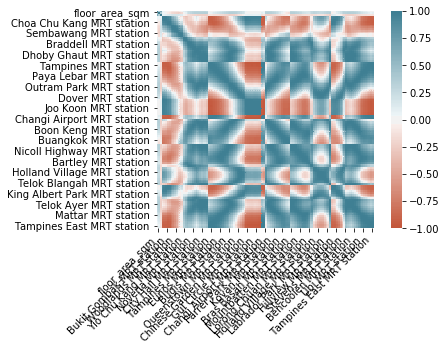

In [46]:
GetCorrelationPlot(final_df)

In [47]:
final_df['storey_range'] = final_df['storey_range'].astype('category')

In [48]:
final_df.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price,Jurong East MRT station,Bukit Batok MRT station,Bukit Gombak MRT station,...,Bendemeer MRT station,Geylang Bahru MRT Station,Mattar MRT station,Ubi MRT station,Kaki Bukit MRT Station,Bedok North MRT station,Bedok Reservoir MRT station,Tampines West MRT station,Tampines East MRT station,Upper Changi MRT station
0,ANG MO KIO,3 ROOM,SmallStorey,60.0,Improved,70,255000.0,11586.77774,10246.44956,9685.068194,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
1,ANG MO KIO,3 ROOM,SmallStorey,60.0,Improved,69,275000.0,11586.77774,10246.44956,9685.068194,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
2,ANG MO KIO,3 ROOM,SmallStorey,69.0,Improved,69,310000.0,11586.77774,10246.44956,9685.068194,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
3,ANG MO KIO,2 ROOM,SmallStorey,45.0,Improved,69,253000.0,11586.77774,10246.44956,9685.068194,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
4,ANG MO KIO,3 ROOM,SmallStorey,61.0,Improved,68,290000.0,11586.77774,10246.44956,9685.068194,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606


In [49]:
final_df.town.unique()

[ANG MO KIO, BEDOK, BISHAN, BUKIT BATOK, BUKIT MERAH, ..., SERANGOON, TAMPINES, TOA PAYOH, WOODLANDS, YISHUN]
Length: 26
Categories (26, object): [ANG MO KIO, BEDOK, BISHAN, BUKIT BATOK, ..., TAMPINES, TOA PAYOH, WOODLANDS, YISHUN]

(array([4.54480839e-01, 1.78511873e-02, 0.00000000e+00, 6.66262076e-01,
        0.00000000e+00, 1.34061596e-01, 3.92616771e-01, 0.00000000e+00,
        9.29464574e-04, 4.64732287e-04]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

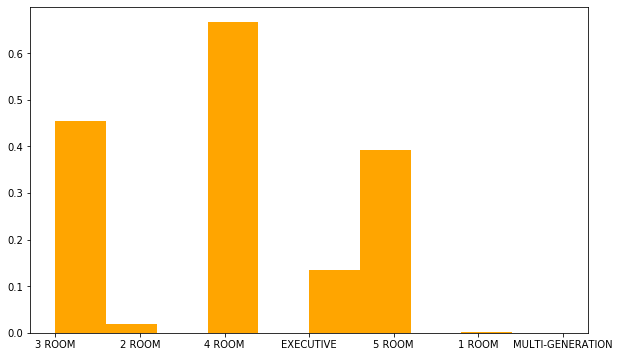

In [50]:
plt.figure(figsize=(10,6))
plt.hist(final_df.flat_type, density=True, bins=10,color=['orange'])

### Clustering

In [51]:
from sklearn.cluster import KMeans
import copy as cp

In [52]:
finalCST_df = cp.deepcopy(final_df)

In [53]:
print(finalCST_df.shape)
finalCST_df.head()

(121934, 126)


,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price,Jurong East MRT station,Bukit Batok MRT station,Bukit Gombak MRT station,...,Bendemeer MRT station,Geylang Bahru MRT Station,Mattar MRT station,Ubi MRT station,Kaki Bukit MRT Station,Bedok North MRT station,Bedok Reservoir MRT station,Tampines West MRT station,Tampines East MRT station,Upper Changi MRT station
0,ANG MO KIO,3 ROOM,SmallStorey,60.0,Improved,70,255000.0,11586.77774,10246.44956,9685.068194,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
1,ANG MO KIO,3 ROOM,SmallStorey,60.0,Improved,69,275000.0,11586.77774,10246.44956,9685.068194,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
2,ANG MO KIO,3 ROOM,SmallStorey,69.0,Improved,69,310000.0,11586.77774,10246.44956,9685.068194,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
3,ANG MO KIO,2 ROOM,SmallStorey,45.0,Improved,69,253000.0,11586.77774,10246.44956,9685.068194,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
4,ANG MO KIO,3 ROOM,SmallStorey,61.0,Improved,68,290000.0,11586.77774,10246.44956,9685.068194,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606


In [54]:
clusterPrep = finalCST_df[finalCST_df.columns[7:]]

In [55]:
clusterPrep.head()

,Jurong East MRT station,Bukit Batok MRT station,Bukit Gombak MRT station,Choa Chu Kang MRT station,Yew Tee MRT station,Kranji MRT station,Marsiling MRT station,Woodlands MRT station,Admiralty MRT station,Sembawang MRT station,...,Bendemeer MRT station,Geylang Bahru MRT Station,Mattar MRT station,Ubi MRT station,Kaki Bukit MRT Station,Bedok North MRT station,Bedok Reservoir MRT station,Tampines West MRT station,Tampines East MRT station,Upper Changi MRT station
0,11586.77774,10246.44956,9685.068194,10409.81507,10293.98887,10057.23072,9491.198678,8902.394698,8322.812426,8434.375798,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
1,11586.77774,10246.44956,9685.068194,10409.81507,10293.98887,10057.23072,9491.198678,8902.394698,8322.812426,8434.375798,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
2,11586.77774,10246.44956,9685.068194,10409.81507,10293.98887,10057.23072,9491.198678,8902.394698,8322.812426,8434.375798,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
3,11586.77774,10246.44956,9685.068194,10409.81507,10293.98887,10057.23072,9491.198678,8902.394698,8322.812426,8434.375798,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606
4,11586.77774,10246.44956,9685.068194,10409.81507,10293.98887,10057.23072,9491.198678,8902.394698,8322.812426,8434.375798,...,7421.041681,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606


In [56]:
#Elbow plot
sse = []
clusterRange = range(1,10)
for k in clusterRange:
    km = KMeans(n_clusters=k)
    km.fit(clusterPrep)
    sse.append(km.inertia_)

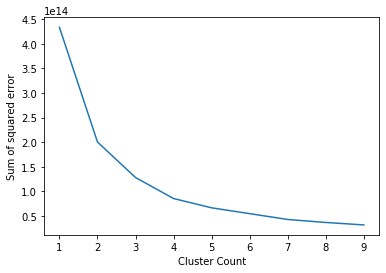

In [57]:
plt.xlabel('Cluster Count')
plt.ylabel('Sum of squared error')
plt.plot(clusterRange,sse)

In [58]:
km = KMeans(n_clusters=4)

In [59]:
predicted_Cluster = km.fit_predict(clusterPrep)
print(predicted_Cluster)

[2 2 2 ... 0 0 1]


In [60]:
clusteredColumns = clusterPrep.columns
print(clusteredColumns)
print(type(clusteredColumns))

Index(['Jurong East MRT station', 'Bukit Batok MRT station',
       'Bukit Gombak MRT station', 'Choa Chu Kang MRT station',
       'Yew Tee MRT station', 'Kranji MRT station', 'Marsiling MRT station',
       'Woodlands MRT station', 'Admiralty MRT station',
       'Sembawang MRT station',
       ...
       'Bendemeer MRT station', 'Geylang Bahru MRT Station',
       'Mattar MRT station', 'Ubi MRT station', 'Kaki Bukit MRT Station',
       'Bedok North MRT station', 'Bedok Reservoir MRT station',
       'Tampines West MRT station', 'Tampines East MRT station',
       'Upper Changi MRT station'],
      dtype='object', length=119)
<class 'pandas.core.indexes.base.Index'>


In [61]:
final_df['AminitiesCluster'] = predicted_Cluster

In [62]:
final_df.AminitiesCluster.unique()

array([2, 0, 3, 1])

In [63]:
final_df.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price,Jurong East MRT station,Bukit Batok MRT station,Bukit Gombak MRT station,...,Geylang Bahru MRT Station,Mattar MRT station,Ubi MRT station,Kaki Bukit MRT Station,Bedok North MRT station,Bedok Reservoir MRT station,Tampines West MRT station,Tampines East MRT station,Upper Changi MRT station,AminitiesCluster
0,ANG MO KIO,3 ROOM,SmallStorey,60.0,Improved,70,255000.0,11586.77774,10246.44956,9685.068194,...,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606,2
1,ANG MO KIO,3 ROOM,SmallStorey,60.0,Improved,69,275000.0,11586.77774,10246.44956,9685.068194,...,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606,2
2,ANG MO KIO,3 ROOM,SmallStorey,69.0,Improved,69,310000.0,11586.77774,10246.44956,9685.068194,...,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606,2
3,ANG MO KIO,2 ROOM,SmallStorey,45.0,Improved,69,253000.0,11586.77774,10246.44956,9685.068194,...,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606,2
4,ANG MO KIO,3 ROOM,SmallStorey,61.0,Improved,68,290000.0,11586.77774,10246.44956,9685.068194,...,7081.755148,7352.239556,8596.977026,9133.510791,10044.62663,11422.48939,11677.87443,13199.5679,14274.52606,2


In [64]:
#Dropping clustered columns:
final_df.drop(clusteredColumns,axis=1,inplace=True)

In [65]:
print(final_df.shape)
final_df.head()

(121934, 8)


,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price,AminitiesCluster
0,ANG MO KIO,3 ROOM,SmallStorey,60.0,Improved,70,255000.0,2
1,ANG MO KIO,3 ROOM,SmallStorey,60.0,Improved,69,275000.0,2
2,ANG MO KIO,3 ROOM,SmallStorey,69.0,Improved,69,310000.0,2
3,ANG MO KIO,2 ROOM,SmallStorey,45.0,Improved,69,253000.0,2
4,ANG MO KIO,3 ROOM,SmallStorey,61.0,Improved,68,290000.0,2


In [66]:
def GetClustername(_aminitiesCluster):
    clusterName = "Cluster-1"
    if _aminitiesCluster==0:
         clusterName = "Cluster-1"
    elif _aminitiesCluster==1:
         clusterName = "Cluster-2"
    elif _aminitiesCluster==2:
         clusterName = "Cluster-3"
    elif _aminitiesCluster==3:
         clusterName = "Cluster-4"
    return clusterName

In [67]:
final_df['AminitiesCluster'] = final_df.AminitiesCluster.apply(GetClustername)

In [68]:
final_df.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price,AminitiesCluster
0,ANG MO KIO,3 ROOM,SmallStorey,60.0,Improved,70,255000.0,Cluster-3
1,ANG MO KIO,3 ROOM,SmallStorey,60.0,Improved,69,275000.0,Cluster-3
2,ANG MO KIO,3 ROOM,SmallStorey,69.0,Improved,69,310000.0,Cluster-3
3,ANG MO KIO,2 ROOM,SmallStorey,45.0,Improved,69,253000.0,Cluster-3
4,ANG MO KIO,3 ROOM,SmallStorey,61.0,Improved,68,290000.0,Cluster-3


In [69]:
final_df['AminitiesCluster'] = final_df['AminitiesCluster'].astype('category')
final_df.dtypes

town                category
flat_type           category
storey_range        category
floor_area_sqm       float64
flat_model          category
remaining_lease        int64
resale_price         float64
AminitiesCluster    category
dtype: object

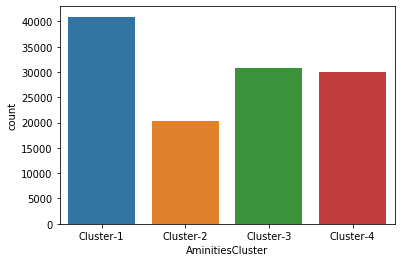

In [70]:
# Plotting Categorical Data
sns.countplot(x="AminitiesCluster", data=final_df)
plt.show()

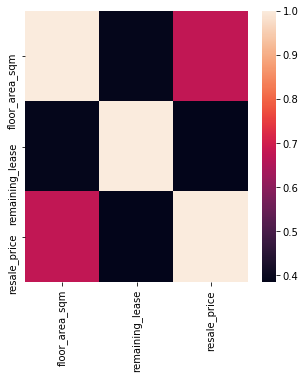

In [71]:
plt.figure(figsize=(5,5))
sns.heatmap(final_df.corr())
plt.show()

### Train and Test split:

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
Y = final_df['resale_price']
X = final_df.drop('resale_price', axis=1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20,random_state=123)

In [74]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(97547, 7)
(24387, 7)
(97547,)
(24387,)


In [75]:
num_Atribute = X_train.select_dtypes(['float64','int64']).columns
cat_Attributes = X_train.select_dtypes(['category']).columns
num_unseenAttribute = X_test.select_dtypes(['float64','int64']).columns
cat_unseenAttribute = X_test.select_dtypes(['category']).columns

In [76]:
print("Num attributes",num_Atribute)
print("cat Attributes",cat_Attributes)

Num attributes Index(['floor_area_sqm', 'remaining_lease'], dtype='object')
cat Attributes Index(['town', 'flat_type', 'storey_range', 'flat_model', 'AminitiesCluster'], dtype='object')


#### Imputing Numeric variables:

In [77]:
numericImputer = SimpleImputer(strategy='median')
numericImputer = numericImputer.fit(X_train[num_Atribute])
X_train[num_Atribute] = numericImputer.transform(X_train[num_Atribute])
X_test[num_Atribute] = numericImputer.transform(X_test[num_Atribute])

C:\Users\Navin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Navin\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Navin\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

#### Imputing Categorical variables:

In [78]:
catImputer = SimpleImputer(strategy="most_frequent")
catImputer = catImputer.fit(X_train[cat_Attributes])
X_train[cat_Attributes] = catImputer.transform(X_train[cat_Attributes])
X_test[cat_Attributes] = catImputer.transform(X_test[cat_Attributes])

C:\Users\Navin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Navin\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Navin\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

#### Standardizing Numeric attributes:

In [79]:
scaler = StandardScaler()

scaler = scaler.fit(X_train[num_Atribute])

X_train[num_Atribute]=scaler.transform(X_train[num_Atribute])
X_test[num_Atribute]=scaler.transform(X_test[num_Atribute])

C:\Users\Navin\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Navin\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Navin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

### Dummification

In [80]:
X_train.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,AminitiesCluster
9065,JURONG EAST,3 ROOM,SmallStorey,-0.529814,New Generation,-0.704016,Cluster-4
17943,TAMPINES,EXECUTIVE,SmallStorey,2.078780,Maisonette,0.212764,Cluster-1
60994,TAMPINES,4 ROOM,SmallStorey,0.163094,Model A,0.396120,Cluster-1
116437,QUEENSTOWN,EXECUTIVE,MediumStorey,2.119539,Apartment,0.121086,Cluster-3
18368,TOA PAYOH,3 ROOM,SmallStorey,-1.181962,Improved,-1.804152,Cluster-3


In [81]:
print(X_train.shape)
print(X_test.shape)

(97547, 7)
(24387, 7)


In [82]:
print("FLAT TYPE ",len(X_train.flat_type.unique()))
print("STOREY RANGE ",len(X_train.storey_range.unique()))
print("FLAT MODEL ",len(X_train.flat_model.unique()))
print("Aminities Cluster ",len(X_train.AminitiesCluster.unique()))

FLAT TYPE  7
STOREY RANGE  3
FLAT MODEL  20
Aminities Cluster  4


In [83]:
print("FLAT TYPE ",len(X_test.flat_type.unique()))
print("STOREY RANGE ",len(X_test.storey_range.unique()))
print("FLAT MODEL ",len(X_test.flat_model.unique()))
print("Aminities Cluster ",len(X_test.AminitiesCluster.unique()))

FLAT TYPE  7
STOREY RANGE  3
FLAT MODEL  19
Aminities Cluster  4


In [84]:
X_train = pd.get_dummies(X_train,columns=cat_Attributes,drop_first=True)
X_test = pd.get_dummies(X_test,columns=cat_unseenAttribute,drop_first=True)

In [85]:
print(X_train.shape)
print(X_test.shape)

(97547, 57)
(24387, 56)


In [86]:
print((cat_Attributes))
print((cat_unseenAttribute))

Index(['town', 'flat_type', 'storey_range', 'flat_model', 'AminitiesCluster'], dtype='object')
Index(['town', 'flat_type', 'storey_range', 'flat_model', 'AminitiesCluster'], dtype='object')


In [87]:
# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]

In [88]:
print(X_train.shape)
print(X_test.shape)

(97547, 57)
(24387, 57)


In [89]:
X_train.dtypes

floor_area_sqm                       float64
remaining_lease                      float64
town_BEDOK                             uint8
town_BISHAN                            uint8
town_BUKIT BATOK                       uint8
town_BUKIT MERAH                       uint8
town_BUKIT PANJANG                     uint8
town_BUKIT TIMAH                       uint8
town_CENTRAL AREA                      uint8
town_CHOA CHU KANG                     uint8
town_CLEMENTI                          uint8
town_GEYLANG                           uint8
town_HOUGANG                           uint8
town_JURONG EAST                       uint8
town_JURONG WEST                       uint8
town_KALLANG/WHAMPOA                   uint8
town_MARINE PARADE                     uint8
town_PASIR RIS                         uint8
town_PUNGGOL                           uint8
town_QUEENSTOWN                        uint8
town_SEMBAWANG                         uint8
town_SENGKANG                          uint8
town_SERAN

In [90]:
X_train.head()

,floor_area_sqm,remaining_lease,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,...,flat_model_Premium Apartment.,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,AminitiesCluster_Cluster-2,AminitiesCluster_Cluster-3,AminitiesCluster_Cluster-4
9065,-0.529814,-0.704016,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
17943,2.078780,0.212764,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60994,0.163094,0.396120,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116437,2.119539,0.121086,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
18368,-1.181962,-1.804152,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Applying PCA for Dimensionality reduction:

In [91]:
from sklearn.decomposition import PCA 
from matplotlib.pyplot import figure

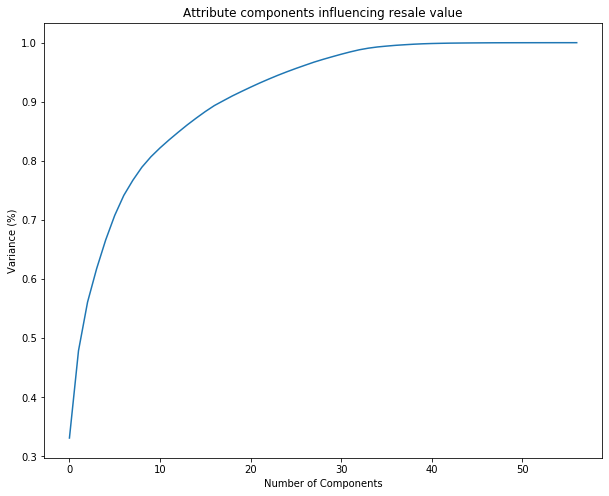

In [92]:
pca = PCA().fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Attribute components influencing resale value')
plt.show()

In [93]:
pca = PCA(n_components = 30) 
X_train_PCA = pca.fit_transform(X_train) 
X_test_PCA = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

### MAPE

In [94]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Model Building:

### Linear model

In [95]:
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#### Ridge Regression:

In [96]:
ridgeRegression = Ridge(alpha=0.5)

In [97]:
ridgeRegression.fit(X_train,Y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [98]:
redge_trainPred = ridgeRegression.predict(X_train)
redge_testPred = ridgeRegression.predict(X_test)

In [99]:
print("mean_absolute_percentage_error TRAIN",mean_absolute_percentage_error(Y_train,redge_trainPred))
print("mean_absolute_percentage_error TEST",mean_absolute_percentage_error(Y_test,redge_testPred))

mean_absolute_percentage_error TRAIN 9.801845692698082
mean_absolute_percentage_error TEST 9.751492780673795


#### Normal Linear Regression:

In [100]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train,Y_train)

In [101]:
trainPred = model.predict(X_train)
testPred = model.predict(X_test)

In [102]:
print("mean_absolute_percentage_error TRAIN",mean_absolute_percentage_error(Y_train,trainPred))
print("mean_absolute_percentage_error TEST",mean_absolute_percentage_error(Y_test,testPred))

mean_absolute_percentage_error TRAIN 9.801584009758479
mean_absolute_percentage_error TEST 9.751411737465872


#### statsmodels Linear Regression:

In [103]:
import statsmodels.api as sm

In [104]:
OLS_models = sm.OLS(Y_train,X_train).fit()

In [105]:
OLS_models.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Ordinary least squares
===================================================================================================
Model:                         OLS                   Adj. R-squared (uncentered):      0.986       
Dependent Variable:            resale_price          AIC:                              2408175.3990
Date:                          2020-05-22 23:18      BIC:                              2408697.2440
No. Observations:              97547                 Log-Likelihood:                   -1.2040e+06 
Df Model:                      55                    F-statistic:                      1.252e+05   
Df Residuals:                  97492                 Prob (F-statistic):               0.00        
R-squared (uncentered):        0.986                 Scale:                            3.0822e+09  
---------------------------------------------------------------------------------------------------
                                     Coef.      Std.Err.     t     P>|t|     [0.025       0.975]   
---------------------------------------------------------------------------------------------------
floor_area_sqm                      67940.3661   779.6316  87.1442 0.0000   66412.2972   69468.4350
remaining_lease                     46465.7380   328.3399 141.5172 0.0000   45822.1956   47109.2804
town_BEDOK                          37167.8980  2061.2553  18.0317 0.0000   33127.8616   41207.9343
town_BISHAN                         74536.0844  1606.5666  46.3946 0.0000   71387.2326   77684.9362
town_BUKIT BATOK                   -76959.0118  7582.9221 -10.1490 0.0000  -91821.4506  -62096.5731
town_BUKIT MERAH                   101703.9850  1283.7351  79.2251 0.0000   99187.8793  104220.0907
town_BUKIT PANJANG                -130032.1480  7599.2890 -17.1111 0.0000 -144926.6658 -115137.6303
town_BUKIT TIMAH                   171962.5905  6261.1985  27.4648 0.0000  159690.7146  184234.4664
town_CENTRAL AREA                   98082.3413  2499.6773  39.2380 0.0000   93183.0030  102981.6795
town_CHOA CHU KANG                -158926.6899  7586.2619 -20.9493 0.0000 -173795.6746 -144057.7052
town_CLEMENTI                       31812.9735  7612.9247   4.1788 0.0000   16891.7301   46734.2169
town_GEYLANG                        33878.2557  1522.5613  22.2508 0.0000   30894.0534   36862.4581
town_HOUGANG                       -25171.6364  1968.6045 -12.7865 0.0000  -29030.0782  -21313.1946
town_JURONG EAST                   -56671.5897  7620.9257  -7.4363 0.0000  -71608.5150  -41734.6644
town_JURONG WEST                  -117993.2619  7563.7235 -15.5999 0.0000 -132818.0716 -103168.4522
town_KALLANG/WHAMPOA                41358.0744  1376.9459  30.0361 0.0000   38659.2766   44056.8723
town_MARINE PARADE                 200109.4235  2973.4478  67.2988 0.0000  194281.5005  205937.3465
town_PASIR RIS                     -55002.6116  2212.2182 -24.8631 0.0000  -59338.5335  -50666.6897
town_PUNGGOL                       -67056.3224  2212.7998 -30.3038 0.0000  -71393.3841  -62719.2607
town_QUEENSTOWN                    105071.6840  1460.9784  71.9187 0.0000  102208.1834  107935.1845
town_SEMBAWANG                     -52814.2701  1049.7650 -50.3106 0.0000  -54871.7973  -50756.7429
town_SENGKANG                      -71114.6050  2124.0931 -33.4800 0.0000  -75277.8027  -66951.4073
town_SERANGOON                     -10391.5370  1497.8357  -6.9377 0.0000  -13327.2775   -7455.7965
town_TAMPINES                        1288.8176  2071.2547   0.6222 0.5338   -2770.8174    5348.4526
town_TOA PAYOH                      42177.8958  1355.7971  31.1093 0.0000   39520.5495   44835.2422
town_WOODLANDS                     -32113.6351   770.9138 -41.6566 0.0000  -33624.6171  -30602.6532
town_YISHUN                         22414.5316   805.9303  27.8120 0.0000   20834.9176   23994.1456
flat_type_2 ROOM                   334550.8183  5841.0027  57.2763 0.0000  323102.521

In [106]:
trainPred = OLS_models.predict(X_train)
testPred = OLS_models.predict(X_test)

In [107]:
print("mean_absolute_percentage_error TRAIN",mean_absolute_percentage_error(Y_train,trainPred))
print("mean_absolute_percentage_error TEST",mean_absolute_percentage_error(Y_test,testPred))

mean_absolute_percentage_error TRAIN 9.911689562051738
mean_absolute_percentage_error TEST 9.892380544557605


In [108]:
#Checking error for constannt variance:
modelResidual = OLS_models.resid

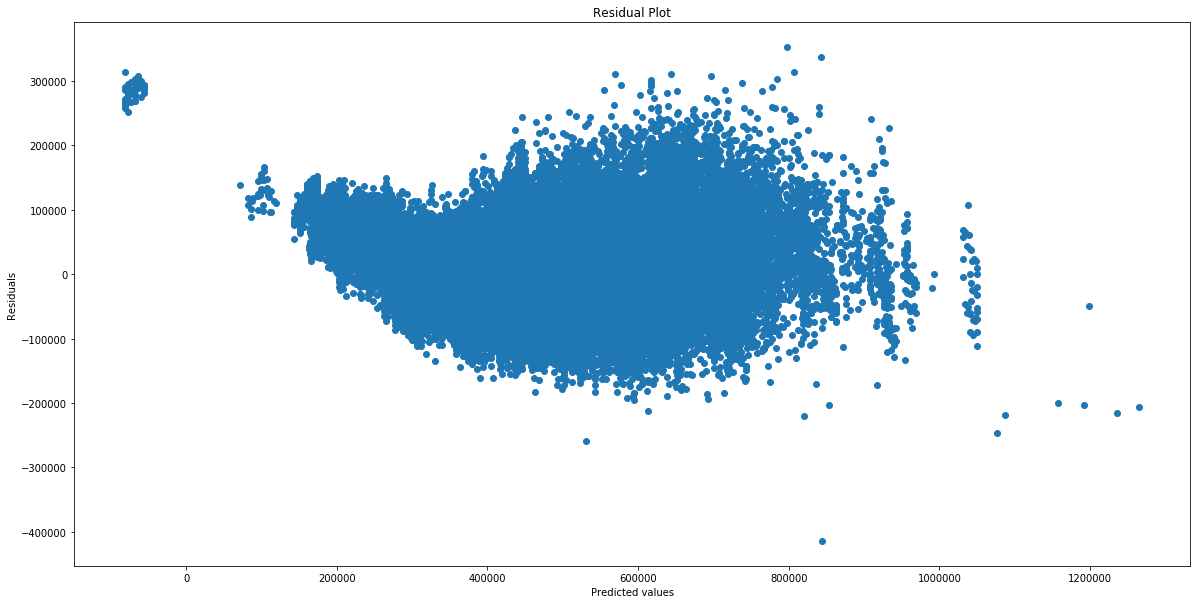

In [109]:
fig = plt.figure(figsize=(20,10))
plt.scatter(trainPred,modelResidual)
plt.title( "Residual Plot" );
plt.xlabel( "Predicted values")
plt.ylabel( "Residuals");

#### Residual Plots:

In [110]:
def residual_plots(model):
    # fitted values (need a constant term for intercept)
    model_fitted_y = model.fittedvalues

    # model residuals
    model_residuals = model.resid

    # normalized residuals
    model_norm_residuals = model.get_influence().resid_studentized_internal

    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

    # absolute residuals
    model_abs_resid = np.abs(model_residuals)

    # leverage, from statsmodels internals
    model_leverage = model.get_influence().hat_matrix_diag

    # cook's distance, from statsmodels internals
    model_cooks = model.get_influence().cooks_distance[0]


    plot_lm_1 = plt.figure(1)
    

    plot_lm_1.axes[0] = sns.regplot(model_fitted_y, model_residuals, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')

    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]

    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i,xy=(model_fitted_y[i],model_residuals[i]));
    
    
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)


    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]

    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i, xy=(np.flip(QQ.theoretical_quantiles, 0)[r],model_norm_residuals[i]));
    
    
    plot_lm_3 = plt.figure(3)
    plot_lm_3.axes[0] = sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,lowess=True,scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_3.axes[0].set_title('Normalized Residuals vs Fitted')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('Normalized Residuals')

#     # annotations
#     abs_resid = model_abs_resid.sort_values(ascending=False)
#     abs_resid_top_3 = abs_resid[:3]
    

#     for i in abs_resid_top_3.index:
#         plot_lm_3.axes[0].annotate(i, xy=(model_fitted_y[i], model_residuals[i]));
    
    plot_lm_4 = plt.figure(4)


    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
    sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_4.axes[0].set_xlim(0, 0.20)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i,xy=(model_leverage[i],model_norm_residuals[i]))
    
    # shenanigans for cook's distance contours
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=1, ls='--', color='red')

    p = len(model.params) # number of model parameters

    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),np.linspace(0.001, 0.200, 50),'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),np.linspace(0.001, 0.200, 50)) # 1 line
    plt.legend(loc='upper right');

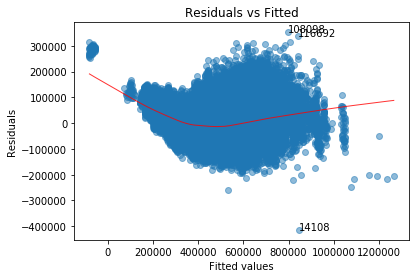

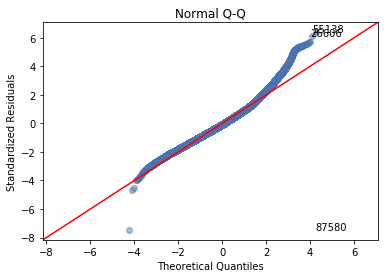

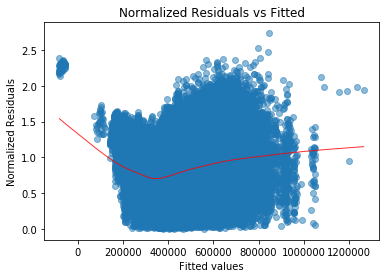

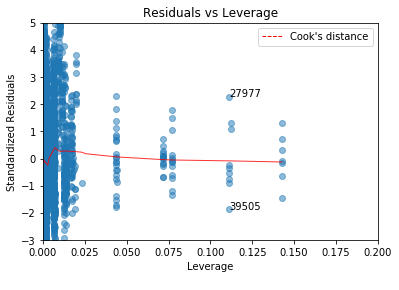

In [111]:
residual_plots(OLS_models)

### Decission Tree

In [112]:
from sklearn.tree import DecisionTreeRegressor

In [113]:
regressor = DecisionTreeRegressor(criterion='mse',max_depth=200,random_state=123,min_samples_leaf=5)

In [114]:
regressor.fit(X_train_PCA,Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=200,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=123, splitter='best')

In [115]:
trainPred_DT = regressor.predict(X_train_PCA)
testPred_DT = regressor.predict(X_test_PCA)

In [116]:
print("mean_absolute_percentage_error TRAIN",mean_absolute_percentage_error(Y_train,trainPred_DT))
print("mean_absolute_percentage_error TEST",mean_absolute_percentage_error(Y_test,testPred_DT))

mean_absolute_percentage_error TRAIN 5.2999688537262735
mean_absolute_percentage_error TEST 6.181788038417481


### Check without PCA

In [117]:
regressor.fit(X_train,Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=200,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=123, splitter='best')

In [118]:
trainPred_DT_W = regressor.predict(X_train)
testPred_DT_W = regressor.predict(X_test)

In [119]:
print("mean_absolute_percentage_error TRAIN",mean_absolute_percentage_error(Y_train,trainPred_DT_W))
print("mean_absolute_percentage_error TEST",mean_absolute_percentage_error(Y_test,testPred_DT_W))

mean_absolute_percentage_error TRAIN 5.527840197913572
mean_absolute_percentage_error TEST 6.121434475899908
